# A text classification example, step by step
We will work with a dataset containing messages from several [usenet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup).  A newsgroup, in case you don't know, is just like a forum.  Before the adoption of the World Wide Web, Usenet newsgroups were among the most popular Internet services.

## Load the data

We'll fetch data from two newsgroups:
- `rec.autos` for discussing about cars, and
- `sci.space` for space nerds.

In [ ]:
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=False)
from IPython.core.display import display, HTML
import sklearn.ensemble
import collections

The dataset is already split in separate training and testing sets.  They are split by date: the 60% oldest messages are used for training, the 40% newest for testing.  More info in the [sklearn docs](https://scikit-learn.org/stable/datasets/index.html#newsgroups-dataset) and the [dataset website](http://qwone.com/~jason/20Newsgroups/).

In [ ]:
categories = ['rec.autos','sci.space']

from sklearn.datasets import fetch_20newsgroups
ds_tr = fetch_20newsgroups(subset='train',
                           categories=categories,
                           remove=('headers', 'footers', 'quotes')) # Keep just the messages
ds_te = fetch_20newsgroups(subset='test',
                           categories=categories,
                           remove=('headers', 'footers', 'quotes'))

## Understand the data

Let's have a look at the training data, which is in the `ds_tr` variable 

In [ ]:
print(f"We have {len(ds_tr.data)} training instances")
print(ds_tr.target)
y_names = ds_tr.target_names
for label in range(len(y_names)):
    print(f"y = {label} means that the message is from the {y_names[label]} newsgroup")
    
# Just for peace of mind, let's make sure that
assert(ds_tr.target_names == ds_te.target_names)

Given a message text, we want to guess which newsgroup it comes from.  Can you?

Execute the cell below again to get a new post.

In [ ]:
ix = np.random.randint(len(ds_tr.data))

display(HTML(f'<h3>Newsgroup (select to reveal): <p style="color:#FFFFFF">{y_names[ds_tr.target[ix]]}</p></h3>'))
display(HTML('<h3>Message text:<h3>'))
print(ds_tr.data[ix])

## Implement a function to create a list of numeric features for a given message
Let's begin with the simplest option. It won't work very well, but it's a start

In [ ]:
def compute_features_for_string(s):
    return [
        len(s),       # length of the string
        s.count("\n") # number of newlines in the string
    ]

# Test...
compute_features_for_string("Hey, I'm a string with two lines\nHello")

## Implement a function to compute a feature matrix for a dataset
We'll use this function to compute features for each instance in the training set and testing set.

In [ ]:
def compute_features(data): # data is a list of strings
    ret = []
    for s in data:
        ret.append(compute_features_for_string(s))
    return np.array(ret)

# Test...
compute_features([
    "Hey, I'm a string with two lines\nHello",
    "A short string",
    "A very loooooooong string\nwith many many\n\n\n\n\nnewlines"
])

## Solve the classification problem
We now build a feature matrix for the training and testing sets.

In [ ]:
X_tr = compute_features(ds_tr.data)
y_tr = ds_tr.target
X_te = compute_features(ds_te.data)
y_te = ds_te.target

print(X_tr.shape, y_tr.shape, sum(y_tr==0), sum(y_tr==1)) 
print(X_te.shape, y_te.shape, sum(y_te==0), sum(y_te==1))

Let's train a classifier and evaluate it on the testing set

In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(X_tr, y_tr)

yhat_te = clf.predict(X_te)
yscores_te = clf.predict_proba(X_te)
print("Accuracy: ",np.mean(y_te==yhat_te))
print("AUC: ", sklearn.metrics.roc_auc_score(
    y_true=y_te,
    y_score=yscores_te[:,1]))

Note that we used [this useful function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) from sklearn.

The performance of our classifier is pretty poor, but still better than a trivial classifier!  Note that the problem is not the classifier itself (indeed, the random forest classifier we used is pretty powerful and used in many state-of-the-art applications!), but instead the poor features we are using.  Garbage in, garbage out.

### Exercise 1
Write a function
```
def draw_ROC(y_true, y_scores):
    ...
```
that draws the ROC curve given:
- the array of true labels (0 or 1)
- the array of scores returned by the classifier for class=1

In order to compute the FPR and TPR values for each threshold, you can implement the necessary function yourself or use [this function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) provided by sklearn; read the documentation and learn how to use it.

In [ ]:
# Solution

### Exercise 2
Which AUC do you expect to obtain if your features were completely useless? For example, if the features for every message were random numbers?  Compute the AUC and draw the ROC curve.

In [ ]:
# Solution

### Exercise 3

Make this mental experiment: "We train a 1-nearest-neighbor classifier on our training data, and then evaluate the trained classifier **on the training data itself**".  What accuracy value do you think you will get?

Once you make up your mind, implement it and check if you guessed correctly: it's just a small change on the code above, use `sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)).  Make sure you understand the result!

## Learn some tricks with strings, so we can extract better features

### Count how many digits there are in a string

In [ ]:
def count_digits(s):
    counts = []
    for i in range(10):
        counts.append(s.count(str(i)))
    return sum(counts)

count_digits("here is a string with several digits: 0000 1111 2222 :)")

This is the same, but more elegant; it uses [list comprehensions](https://jakevdp.github.io/WhirlwindTourOfPython/11-list-comprehensions.html), a great python feature which looks confusing at first but is actually really useful.

In [ ]:
def count_digits(s):
    return sum([s.count(str(i)) for i in range(10)])

count_digits("here is a string with several digits: 0000 1111 2222 :)")

### Exercise
Write (and test) functions for computing (some of) the following features for a given string:
- the number of digits in the message
- the fraction of the message's characters that are digits
- some features computed *per line* on the input string (use [str.splitlines()](https://docs.python.org/3/library/stdtypes.html#str.splitlines)):
    - the maximum number of digits per line
    - the average number of characters per line
    
Add these features to the dataset: did the AUC improve?

### Tokenization

In python, you can tokenize strings (i.e. divide the string in words) with the `str.split()` method, like this

In [ ]:
"hey, i'm a string\nand you should split me.".split()

However, note that the result is not perfect. I.e. there is a comma after "hey".  We could do better with some ad-hoc regex, but if you think about it solving this properly is complicated.  Just because it's so easy, we'll use a proper library for tokenizing words in english text, from NLTK, the [Natural Language Toolkit](https://www.nltk.org/).

You'll need to install `nltk` (super easy with conda).  If you have problem installing NLTK, feel free to use str.split.  Otherwise...

In [ ]:
import nltk
nltk.word_tokenize("hey, i'm a string. Don't split me!")

Note that:
- the comma is a separate token
- the `'m` in `i'm` is a token by itself (which is correct, because it stands for "am")
- the `n't` in `don't` is a token by itself (which is correct, because it stands for "not")

### Get all words in a message

In [ ]:
words = nltk.word_tokenize("This is a message!")
print("is" in words)
print("age" in words) # We are looking for a full word, not a word part
print("this" in words) # Careful! Case sensitive...

Let's forget case and only operate on lowercase words

In [ ]:
"HeY".lower()

In [ ]:
message = "This is a message!"
words = nltk.word_tokenize(message)
lwords = []
for w in words:
    lwords.append(w.lower())
lwords

Or, better, using list comprehension:

In [ ]:
lwords = [w.lower() for w in nltk.word_tokenize(message)]
lwords

### Is there a given word in the message?
You can use the `in` operator

In [ ]:
print("this" in lwords)

### Which words are in the message?
For each word in a vocabulary, we want to know whether it's in the message or not.

We are computing something similar to the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model) which is frequently used in Natural Language Processing.

In [ ]:
vocabulary = ["message", "mickey", "one"]

presence = []
for v in vocabulary:
    presence.append(v in lwords)
presence

In [ ]:
# or equivalently with list comprehensions
presence = [(v in lwords) for v in vocabulary]
presence

Let's now define a meaningful vocabulary and use the presence (or absence) of each word in each message as a feature. Note that we are *not* telling the classifier whether a feature should be indicative of one class or the other.  Also, in this way we might add irrelevant features, but we expect the classifier to figure that out and not be too confused (unless we add too many of them).

In [ ]:
def compute_features_for_string(s, vocabulary):
    lwords = [w.lower() for w in nltk.word_tokenize(s)]
    presence = [(v in lwords) for v in vocabulary]
    ret = [len(s),s.count("\n")] + presence # the + concatenates two lists
    return ret

def compute_features(data, vocabulary):
    ret = []
    for s in data:
        ret.append(compute_features_for_string(s, vocabulary))
    return np.array(ret)

vocabulary = ["car","engine","auto","moon","planet",
              "ford","piston","fuel","entry","atmosphere"]

X_tr = compute_features(ds_tr.data, vocabulary)
y_tr = ds_tr.target
X_te = compute_features(ds_te.data, vocabulary)
y_te = ds_te.target

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
clf.fit(X_tr,y_tr)
yhat_te = clf.predict_proba(X_te)

auc = sklearn.metrics.roc_auc_score(y_te, yhat_te[:,1])
accuracy = sklearn.metrics.accuracy_score(y_te, yhat_te[:,1]>0.5)
print("AUC: ",auc)
print("Accuracy: ",auc)

### Challenge!
Can you get to AUC > 0.85 by adding less than 5 additional words to the vocabulary?
What AUC can you get if you use 30 words in total?

Note: every time you train the random forest classifier, it will be (slightly) different because the training algorithm is stochastic, so the AUC will change a little bit.

### Looking for frequent words in the dataset
You can use the `collections.Counter()` Python class ([docs](https://docs.python.org/3.7/library/collections.html#collections.Counter)).

It works like this:

In [ ]:
c = collections.Counter()
c.update(["red","red","blue"])
print(c)
c.update(["violet","red","red","green","green"])
print(c)
print(c.most_common(2)) # The two most common elements

Let's use a counter to find the most frequent words in the dataset.

In [ ]:
c = collections.Counter()
for s in ds_tr.data:
    lwords = [w.lower() for w in nltk.word_tokenize(s)]
    c.update(lwords)
c.most_common(1000)

Let's put the 200 most common words in a list

In [ ]:
vocabulary = []
for w,count in c.most_common(200): # we are using tuple unpacking here
    vocabulary.append(w)
vocabulary

In [ ]:
# Better yet, with a list comprehension
vocabulary = [w for w,count in c.most_common(200)]

### Exercise
What AUC can you get if you use the $N$ most common words in the vocabulary for computing features?
Compute the AUC vs $N$ for $N = {10, 20, 40, 100, 200, 400, 1000, 2000, 4000, 10000}$.

Plot the results with a blue line (using `go.Scatter(..., mode = 'lines+markers')`), with $N$ on $x$ and the AUC on $y$.

## Advanced: *stemming*
Did you notice that, so far, we considered similar words such as "car" vs "cars" (or "launch" vs "launched") as different words? That's probably not ideal.  It would be great if we could reduce all words to a "simple" form, so that we count both "car" and "cars" as the same word.  This operation in the Natural Language Processing literature  is called *stemming* (closely related: *lemmatization*).  Read about them [here](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
for word in ["car", "cars", "launch", "launched", "missile", "missiles", "missilistic", "transparent", 
             "biology", "biologic"]:
    print(f"{word} → {ps.stem(word)}")

Let's apply a stemmer to all the words of a random message in the training set.  Note that some stems do not correspond to real words: that's OK.  Run the cell again to see another message.

In [ ]:
ix = np.random.randint(len(ds_tr.data))
s = ds_tr.data[ix]

print()

words = nltk.word_tokenize(s)
for w in words:
    print(ps.stem(w), end=" ")

### Exercise (difficult)
How does the performance of our classifier change if instead of using the presence of words as features, we use the presence of words *that stem in a given way*?  Note that the motivation of this change is similar to the reason why we used `str.lower()` previously.  And the implementation is very similar.  You should:
- Compute the $N$ most frequent word stems in the training data.  Use those as a `stem_vocabulary`.
- For each message: tokenize it, convert each token to lowercase and extract its stem.  Then, check if each element in `stem_vocabulary` is in the message.

Compare the performance of the classifier which uses these features to the performance of the classifier that uses the presence of unstemmed words as features (which you computed in a previous exercise).

The cell below solves the first point (computing `stem_vocabulary`).

In [ ]:
c = collections.Counter()
for s in ds_tr.data:
    stems = [ps.stem(w.lower()) for w in nltk.word_tokenize(s)]
    c.update(stems)
N = 200
stem_vocabulary = [stem for stem,count in c.most_common(N)]

## Examining the results of the classifier
Let's print the classifier predictions (you can do this with any classifier, but it is more fun if it works reasonably well, i.e. AUC > 0.8).

Make sure the classifier scores are in variable `yscores_te`.

In [ ]:
for i in range(len(ds_te.data)):
    print(f"Instance {i} - True class {y_te[i]} =====================================")
    for c in [0,1]:
        print(f"Class {c} ({y_names[c]}) score: {yscores_te[i,c]:0.2f}")
    print()
    print(ds_te.data[i])
    print()

### Exercise (easy)
Change the cell above in order to write for each instance whether the classifier estimate is correct or not.

### Exercise (easy)
Display only the messages that were classified wrong

### Exercise (medium)
Sort the messages from the one where the classifier was *most wrong* (i.e. where the classifier assigned a very low score to the true class) to the one in which it was *most right* (i.e. where the classifier assigned a very high score to the true class).

### Exercise
- Consider only the testing observations with true class = 1.  Draw the histogram of the score for **class 1** returned by the classifier for these observations.  Do we want these scores to be high or low?
- Consider only the testing observations with true class = 0.  Draw the histogram of the score for **class 1** returned by the classifier for these observations.  Do we want these scores to be high or low?  Note: if the classifier is good, it should return high scores for class 0, which means that the scores for class 1 will be ...?
- Draw both histograms on the same axes

Results should look similar to this:
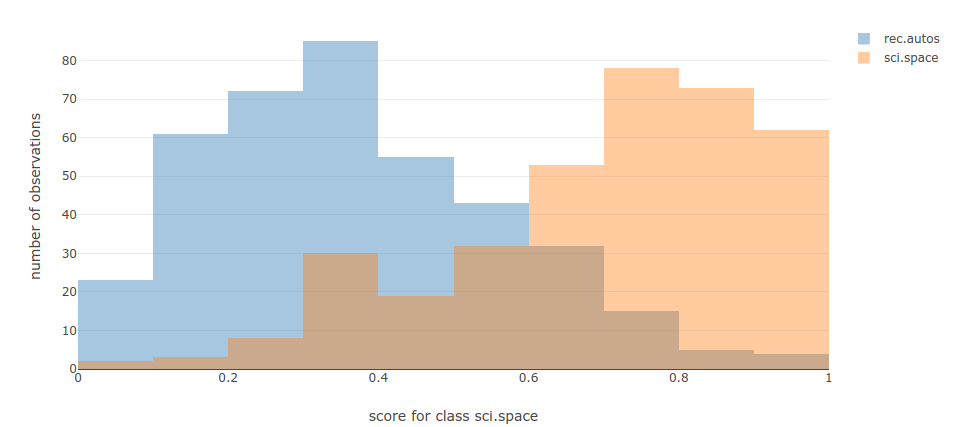

### Exercise
Write a cell that, given some text (you can use the `input()` function) prints the predictions of the classifier.
Assume you have a trained classifier and a function to compute the features (careful: should be the same type on which the classifier has been trained on!!).

## Exercise: extend to all 20 newsgroups!
We just used data from 2 newsgroups so far, but the dataset contains 20 of them.  You can download all the data as shown in the cell below.

Decide on a feature extraction method and train a classifier; then apply it to the testing set. How can you evaluate it?
- Compute the accuracy; is it good? What is the baseline accuracy?  Note: you can find the baseline accuracy also by training and evaluating a [dummy classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). 
- Compute the confusion matrix manually or using [sklearn.metrics.confusion_matrix(...)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) then display it.  Reading a 20x20 matrix of numbers is not very nice, isn't it?
- A good way to visualize patterns in the confusion matrix is to draw it as an heatmap ([plotly docs](https://plot.ly/python/heatmaps/)).  Explore its options, and make sure you use the correct labels for the x/y axes but also for the x/y ticks: i.e. every row and column of the matrix should be annotated with the corresponding newsgroup.

The expected result looks like this:
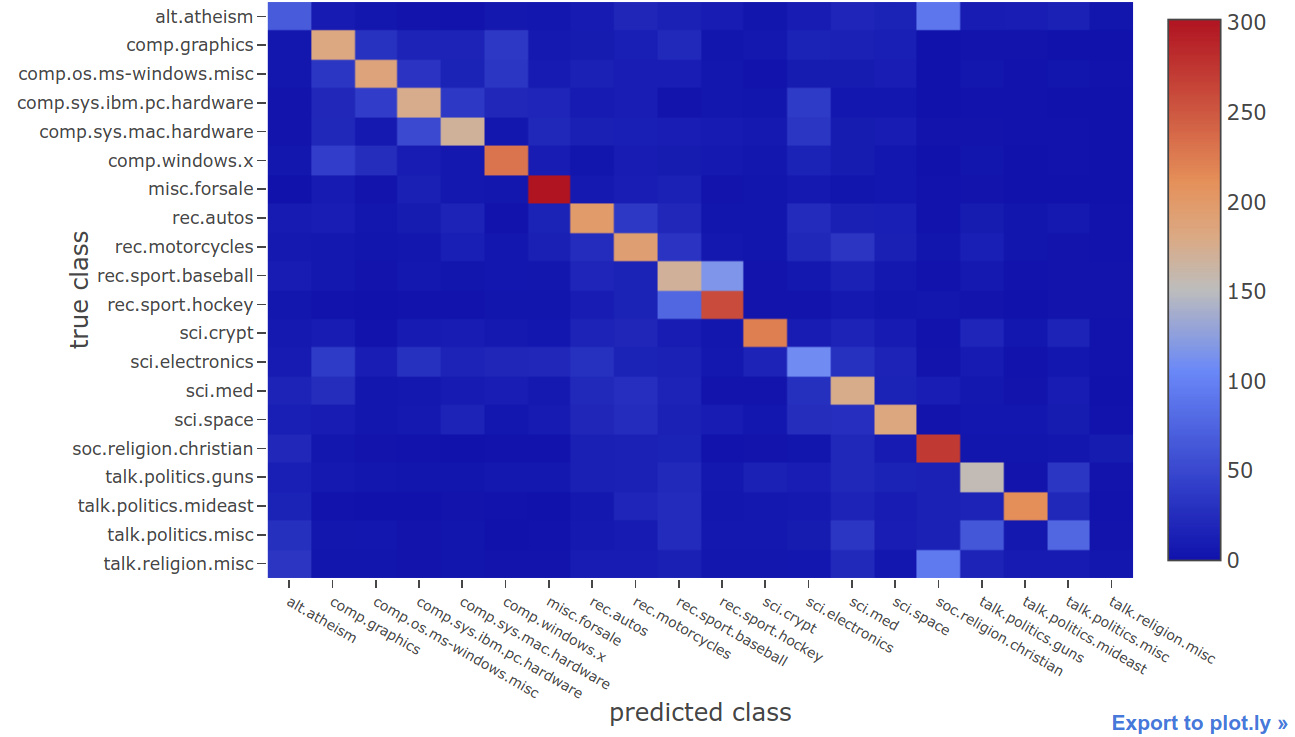

In [ ]:
from sklearn.datasets import fetch_20newsgroups
ds_tr = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))
ds_te = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
y_names = ds_tr.target_names

Hint: once you have your predictions for the test set, use this code to plot a confusion matrix like described above

```
cm = sklearn.metrics.confusion_matrix(...)
trace = go.Heatmap(z=cm,
                   x=y_names,
                   y=y_names)
fig = dict(data=[trace],
           layout=dict(
               yaxis=dict(
                   title="true class",
                   autorange='reversed',
                   automargin=True,
                   tickfont=dict(size=10)),
               xaxis=dict(
                   title="predicted class",
                   automargin=True,
                   tickfont=dict(size=8))))
py.iplot(fig)
```

## Exercise
For each message in the test set, print:
- a) its true class
- b) the 5 top predicted classes and their scores, sorted by descending score (first the top-scoring one)
- c) whether the message has been correctly classified

In [ ]:
for i,s in enumerate(ds_te.data[:100]):
    print("█████████████████████████████████████████████████████")
    print(f"Testing instance {i} - True class {y_names[y_te[i]]}")
    for j in np.argsort(yscores_te[i,:])[:-6:-1]:
        print(f"Score for {y_names[j]}: {yscores_te[i,j]:.3f}")
    print(f"Text:\n{s}\n")

Below, we report the results of points a and b above on the first 20 messages of the testing set.

```
█████████████████████████████████████████████████████
Testing instance 0 - True class rec.autos
Score for sci.med: 0.110
Score for sci.electronics: 0.110
Score for comp.sys.ibm.pc.hardware: 0.080
Score for sci.space: 0.070
Score for comp.sys.mac.hardware: 0.070
Text:
I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

█████████████████████████████████████████████████████
Testing instance 1 - True class comp.windows.x
Score for comp.graphics: 0.120
Score for alt.atheism: 0.110
Score for sci.electronics: 0.110
Score for talk.politics.mideast: 0.070
Score for comp.sys.mac.hardware: 0.060
Text:
I'm not familiar at all with the format of these "X-Face:" thingies, but
after seeing them in some folks' headers, I've *got* to *see* them (and
maybe make one of my own)!

I've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")
and I've managed to compile [un]compface too... but now that I'm *looking*
for them, I can't seem to find any X-Face:'s in anyones news headers!  :-(

Could you, would you, please send me your "X-Face:" header?

I *know* I'll probably get a little swamped, but I can handle it.

	...I hope.

█████████████████████████████████████████████████████
Testing instance 2 - True class alt.atheism
Score for misc.forsale: 0.180
Score for rec.motorcycles: 0.130
Score for talk.politics.misc: 0.110
Score for rec.sport.baseball: 0.090
Score for alt.atheism: 0.090
Text:

In a word, yes.


█████████████████████████████████████████████████████
Testing instance 3 - True class talk.politics.mideast
Score for talk.politics.misc: 0.200
Score for talk.politics.mideast: 0.180
Score for talk.politics.guns: 0.150
Score for sci.crypt: 0.110
Score for soc.religion.christian: 0.060
Text:

They were attacking the Iraqis to drive them out of Kuwait,
a country whose citizens have close blood and business ties
to Saudi citizens.  And me thinks if the US had not helped out
the Iraqis would have swallowed Saudi Arabia, too (or at 
least the eastern oilfields).  And no Muslim country was doing
much of anything to help liberate Kuwait and protect Saudi
Arabia; indeed, in some masses of citizens were demonstrating
in favor of that butcher Saddam (who killed lotsa Muslims),
just because he was killing, raping, and looting relatively
rich Muslims and also thumbing his nose at the West.

So how would have *you* defended Saudi Arabia and rolled
back the Iraqi invasion, were you in charge of Saudi Arabia???


I think that it is a very good idea to not have governments have an
official religion (de facto or de jure), because with human nature
like it is, the ambitious and not the pious will always be the
ones who rise to power.  There are just too many people in this
world (or any country) for the citizens to really know if a 
leader is really devout or if he is just a slick operator.


You make it sound like these guys are angels, Ilyess.  (In your
clarinet posting you edited out some stuff; was it the following???)
Friday's New York Times reported that this group definitely is
more conservative than even Sheikh Baz and his followers (who
think that the House of Saud does not rule the country conservatively
enough).  The NYT reported that, besides complaining that the
government was not conservative enough, they have:

	- asserted that the (approx. 500,000) Shiites in the Kingdom
	  are apostates, a charge that under Saudi (and Islamic) law
	  brings the death penalty.  

	  Diplomatic guy (Sheikh bin Jibrin), isn't he Ilyess?

	- called for severe punishment of the 40 or so women who
	  drove in public a while back to protest the ban on
	  women driving.  The guy from the group who said this,
	  Abdelhamoud al-Toweijri, said that these women should
	  be fired from their jobs, jailed, and branded as
	  prostitutes.

	  Is this what you want to see happen, Ilyess?  I've
	  heard many Muslims say that the ban on women driving
	  has no basis in the Qur'an, the ahadith, etc.
	  Yet these folks not only like the ban, they want
	  these women falsely called prostitutes?  

	  If I were you, I'd choose my heroes wisely,
	  Ilyess, not just reflexively rally behind
	  anyone who hates anyone you hate.

	- say that women should not be allowed to work.

	- say that TV and radio are too immoral in the Kingdom.

Now, the House of Saud is neither my least nor my most favorite government
on earth; I think they restrict religious and political reedom a lot, among
other things.  I just think that the most likely replacements
for them are going to be a lot worse for the citizens of the country.
But I think the House of Saud is feeling the heat lately.  In the
last six months or so I've read there have been stepped up harassing
by the muttawain (religious police---*not* government) of Western women
not fully veiled (something stupid for women to do, IMO, because it
sends the wrong signals about your morality).  And I've read that
they've cracked down on the few, home-based expartiate religious
gatherings, and even posted rewards in (government-owned) newspapers
offering money for anyone who turns in a group of expartiates who
dare worship in their homes or any other secret place. So the
government has grown even more intolerant to try to take some of
the wind out of the sails of the more-conservative opposition.
As unislamic as some of these things are, they're just a small
taste of what would happen if these guys overthrow the House of
Saud, like they're trying to in the long run.

Is this really what you (and Rached and others in the general
west-is-evil-zionists-rule-hate-west-or-you-are-a-puppet crowd)
want, Ilyess?


█████████████████████████████████████████████████████
Testing instance 4 - True class talk.religion.misc
Score for talk.religion.misc: 0.160
Score for alt.atheism: 0.110
Score for comp.sys.ibm.pc.hardware: 0.090
Score for rec.autos: 0.080
Score for rec.motorcycles: 0.060
Text:

I've just spent two solid months arguing that no such thing as an
objective moral system exists.

█████████████████████████████████████████████████████
Testing instance 5 - True class sci.med
Score for sci.med: 0.120
Score for talk.religion.misc: 0.110
Score for soc.religion.christian: 0.090
Score for talk.politics.misc: 0.070
Score for alt.atheism: 0.070
Text:

Elisabeth, let's set the record straight for the nth time, I have not read 
"The Yeast Connection".  So anything that I say is not due to brainwashing 
by this "hated" book.  It's okay I guess to hate the book, by why hate me?
Elisabeth, I'm going to quote from Zinsser's Microbiology, 20th Edition.
A book that you should be familiar with and not "hate". "Candida species 
colonize the mucosal surfaces of all humans during birth or shortly 
thereafter.  The risk of endogenous infection is clearly ever present.  
Indeed, candidiasis occurs worldwide and is the most common systemic 
mycosis."  Neutrophils play the main role in preventing a systemic 
infection(candidiasis) so you would have to have a low neutrophil count or 
"sick" neutrophils to see a systemic infection.  Poor diet and persistent 
parasitic infestation set many third world residents up for candidiasis.
Your assessment of candidiasis in the U.S. is correct and I do not dispute 
it.

What I posted was a discussion of candida blooms, without systemic 
infection.  These blooms would be responsible for local sites of irritation
(GI tract, mouth, vagina and sinus cavity).  Knocking down the bacterial 
competition for candida was proposed as a possible trigger for candida 
blooms.  Let me quote from Zinsser's again: "However, some factors, such as 
the use of a broad-spectrum antibacterial antibiotic, may predispose to 
both mucosal and systemic infections".  I was addressing mucosal infections
(I like the term blooms better).  The nutrition course that I teach covers 
this effect of antibiotic treatment as well as the "cure".  I guess that 
your nutrition course does not, too bad.  



My, my Elisabeth, do I detect a little of Steve Dyer in you?  If you 
noticed my faculty rank, I'm a biochemist, not a microbiologist.
Candida is classifed as a fungus(according to Zinsser's).  But, as you point 
out, it displays dimorphism.  It is capable of producing yeast cells, 
pseudohyphae and true hyphae.  Elisabeth, you are probably a microbiologist 
and that makes a lot of sense to you.  To a biochemist, it's a lot of 
Greek.  So I called it a yeast-like fungus, go ahead and crucify me.

You know Elisabeth, I still haven't been able to figure out why such a small 
little organism like Candida can bring out so much hostility in people in 
Sci. Med.  And I must admitt that I got sucked into the mud slinging too.
I keep hoping that if people will just take the time to think about what 
I've said, that it will make sense.  I'm not asking anyone here to buy into 
"The Yeast Connection" book because I don't know what's in that book, plain 
and simple. And to be honest with you, I'm beginning to wish that it was never 
written.

█████████████████████████████████████████████████████
Testing instance 6 - True class soc.religion.christian
Score for rec.sport.baseball: 0.190
Score for rec.motorcycles: 0.110
Score for talk.politics.misc: 0.100
Score for rec.sport.hockey: 0.090
Score for talk.religion.misc: 0.080
Text:
Dishonest money dwindles away, but he who gathers money little by little makes
it grow. 
Proverbs 13:11


█████████████████████████████████████████████████████
Testing instance 7 - True class soc.religion.christian
Score for comp.graphics: 0.280
Score for sci.med: 0.110
Score for comp.os.ms-windows.misc: 0.100
Score for rec.motorcycles: 0.060
Score for comp.windows.x: 0.060
Text:
A friend of mine managed to get a copy of a computerised Greek and Hebrew 
Lexicon called "The Word Perfect" (That is not the word processing 
package WordPerfect). However, some one wiped out the EXE file, and she 
has not been able to restore it. There are no distributors of the package in 
South Africa. I would appreciate it, if some one could email me the file, or 
at least tell me where I could get it from. 

My email address is
	fortmann@superbowl.und.ac.za     or
	fortmann@shrike.und.ac.za
 
Many thanks.

█████████████████████████████████████████████████████
Testing instance 8 - True class comp.windows.x
Score for comp.windows.x: 0.490
Score for comp.os.ms-windows.misc: 0.080
Score for comp.graphics: 0.080
Score for sci.electronics: 0.050
Score for comp.sys.ibm.pc.hardware: 0.040
Text:
Hi,

   We have a requirement for dynamically closing and opening
different display servers within an X application in a manner such
that at any time there is only one display associated with the client.

   Assumming a proper cleanup is done during the transition should
we anticipate any problems.


█████████████████████████████████████████████████████
Testing instance 9 - True class comp.graphics
Score for comp.graphics: 0.310
Score for comp.sys.ibm.pc.hardware: 0.140
Score for sci.electronics: 0.090
Score for comp.sys.mac.hardware: 0.060
Score for sci.med: 0.050
Text:
:  
: well, i have lots of experience with scanning in images and altering
: them.  as for changing them back into negatives, is that really possible?

: (stuff deleted)

: jennifer urso:  the oh-so bitter woman of utter blahness(but cheerful
: undertones)

I use Aldus Photostyler on the PC and I can turn a colour or black and white
image into a negative or turn a negative into a colour or black and white
image.  I don't know how it does it but it works well.  To test it I scanned
a negative and used Aldus to create a positive.  It looked better than the
print that the film developers gave me.


-- 

█████████████████████████████████████████████████████
Testing instance 10 - True class comp.os.ms-windows.misc
Score for comp.os.ms-windows.misc: 0.760
Score for comp.sys.ibm.pc.hardware: 0.080
Score for comp.graphics: 0.040
Score for rec.sport.baseball: 0.020
Score for misc.forsale: 0.020
Text:
I have uploaded the Windows On-Line Review shareware edition to
ftp.cica.indiana.edu as /pub/pc/win3/uploads/wolrs7.zip.

It is an on-line magazine which contains reviews of some shareware
products...I grabbed it from the Windows On-Line BBS.

--

█████████████████████████████████████████████████████
Testing instance 11 - True class comp.windows.x
Score for comp.graphics: 0.380
Score for comp.windows.x: 0.330
Score for comp.sys.ibm.pc.hardware: 0.080
Score for comp.sys.mac.hardware: 0.070
Score for comp.os.ms-windows.misc: 0.030
Text:
Most graphics systems I have seen have drawing routines that also specify
a color for drawing, like

Drawpoint(x,y,color) or Drawline(x1,y1,x2,y2,color) or
Fillrectangle(x1,y1,x2,y2,color) 

With X, I have to do something like 
XSetForeground(current_color)
XDrawPoint(d,w,x,y)

Why split this into two functions? Why did X designers decide to not associate
the color with the object being drawn, and instead associate it with the
display it is being drawn on?

█████████████████████████████████████████████████████
Testing instance 12 - True class talk.politics.mideast
Score for talk.politics.mideast: 0.890
Score for talk.politics.misc: 0.020
Score for comp.sys.mac.hardware: 0.020
Score for soc.religion.christian: 0.020
Score for sci.med: 0.020
Text:

You *know* that putting something like this out on the newsgroup is *only*
going to generate flames, not discussion. Try adding some substance to
the issue of "gestures" you mentioned.

What is it you feel that Israel *has* offered as a "gesture"? What would
you (*realistically*) expect to see presented by the Arabs/Palestinians
in the way of "gesture"?


What are the "rules" that have been bent by Arab actions? It would seem
that the Israeli deportations were seen by the other side as an example
of "changing the rules". 



█████████████████████████████████████████████████████
Testing instance 13 - True class rec.motorcycles
Score for sci.space: 0.120
Score for rec.motorcycles: 0.120
Score for rec.sport.baseball: 0.090
Score for sci.electronics: 0.090
Score for talk.politics.guns: 0.080
Text:

Accusation?  I thought it was a recommendation.  (I mean, I did grow up there,
I oughta know).


Bring the truck and about 10 pounds of crawfish and we'll talk.




█████████████████████████████████████████████████████
Testing instance 14 - True class alt.atheism
Score for soc.religion.christian: 0.500
Score for talk.religion.misc: 0.250
Score for alt.atheism: 0.160
Score for talk.politics.guns: 0.020
Score for rec.sport.hockey: 0.020
Text:

Probably because it IS rape.


So nothing.  It may work for some, but not for others: it doesn't give any
insight into an overall God or overall truth of a religion- it would seem to be
dependent solely on the individual, as well as individually-created.  And since
Christians have failed to show us how there way of life is in any wy better
than ours, I do not see why the attempt to try it is necessary, or even
particularly attractive.


Well, we will nerver know for sure if we were told the truth or not, but at the
very least there is a bit more evidence pointing to the fact that, say, there
was a military conflict in Vietnam 25 years ago, then there is a supernatural
diety who wants us to live a certain way.  The fact that Jesus warned against
it means nothing.  *I* warn against it too.  Big deal.


This is not true.  The first two choices here (life and death) are scantily
documented, and the last one is total malarky unless one uses the Bible, and
that is totally circular.  Perhaps it be better to use the imagination, or
one's ignorance.  Someone else will address this I'm sure, and refer you to
plenty of documentation...


How is this?  There is nothing more disgusting than Christian attempts to
manipulate/interpret the Old Testament as being filled with signs for the
coming of Christ.  Every little reference to a stick or bit of wood is
autmoatically interpreted as the Cross.  What a miscarriage of philology.


Well, since we have skeptical hearts (thank goodness,) there is no way to get
into us.  Here we have the irreconcilable difference: Christians glorify
exactly what we tend to despise or snub: trust/belief/faith without knowledge. 
If I am lucky one day and I happen to be thinking of God at the same time my
enkephalins go up, then I may associate this as a sign of God (it will "feel"
right, and I will trust without knowing).  Maybe.  Religosity does not seem to
be anything that is conclusively arrived at, but rather it seems to be more of
a sudden affliction...
I believe many of us were willing to die for what we believed, many of us were
not.  The question is, is suchg an attitude reflective of a _correct_ or
healthy morality.  IT would seem not to be.  The same thing could reflect
fanaticism, for example, and is any case an expression of simple selfishness.
-- 

--Adam

█████████████████████████████████████████████████████
Testing instance 15 - True class comp.os.ms-windows.misc
Score for comp.sys.ibm.pc.hardware: 0.340
Score for comp.graphics: 0.170
Score for comp.os.ms-windows.misc: 0.120
Score for comp.sys.mac.hardware: 0.100
Score for comp.windows.x: 0.060
Text:
From article <C68uBG.K2w@world.std.com>, by cfw@world.std.com (Christopher F Wroten):
Good question.
Answer: The EISA bus does move 32 bits rather than ISA's 8/(16?)
        But it still moves it at about the speed as the ISA bus.
        I think that's either 8 or 10 mhz.
        The local bus designs also move 32 bits like the EISA, but
        they move the data at the cpu speed, up to 40 mhz.
        So, on a 33mhz cpu, the local bus is moving 32bit data at
        33 mhz, and the EISA is moving 32bit data at 8 or 10 mhz.
        So the local bus should be 3 to 4 times faster than EISA on
        a 33 mhz cpu.  EISA should be about two (maybe 3) times as
        fast as ISA.

That's a very good question.  The EISA bus does have more advantages
over the ISA bus than just it's width.  For example: more/better 
interrupts and bus mastering.  But these other factors do not impact
 a video card very much.  They have more impact on file servers with 
multiple hard drives, full-throttle network cards, cd-roms, etc.

█████████████████████████████████████████████████████
Testing instance 16 - True class comp.sys.mac.hardware
Score for comp.os.ms-windows.misc: 0.220
Score for comp.graphics: 0.190
Score for comp.sys.ibm.pc.hardware: 0.070
Score for comp.sys.mac.hardware: 0.070
Score for alt.atheism: 0.040
Text:
Iv'e got a problem printing with a StyleWriterII. I am printing from a IIvx
with 20 megs ram. I am trying to print a Quark file that has 2 fonts a couple
of boxes and 3 gradient fills. 

Two things happen: I get a " Disk is full" error, that I can't find documented,
I also have parts of letters that are over one of the gradient fills get cut
off. This only happens to the text over the fill. Text adjecent in a different
box is uneffected.

Any ideas?

█████████████████████████████████████████████████████
Testing instance 17 - True class comp.graphics
Score for rec.sport.baseball: 0.180
Score for comp.graphics: 0.100
Score for comp.windows.x: 0.070
Score for sci.electronics: 0.070
Score for rec.motorcycles: 0.060
Text:
Hello,
i'm interested in those devices too.
Could also send me your suggestions.
Thank in advance.
Regards.
-- 

█████████████████████████████████████████████████████
Testing instance 18 - True class misc.forsale
Score for comp.sys.ibm.pc.hardware: 0.180
Score for comp.sys.mac.hardware: 0.180
Score for sci.electronics: 0.150
Score for misc.forsale: 0.150
Score for rec.motorcycles: 0.070
Text:
I said
what a SILLY boy i was, now i have zillions of messages like
"does that include shipping" 		
"is it scsi"
"what rom version is it"
"will it work on a maximegalon gargantuabrain 9000"
ok, the deal is this - if you live in the twin cities, email me, and set
up a time, sure, you can drop round and grab one for a tenner.
Else
Min order $20 (2 drives) + shipping. No guarantees they are good for
any purpose at all (they look newish & clean), no technical
negotiations. They are model 525 floppytape, part # 960273-639
revision D. 17 pin floppy style connector on the back
Else
They go in the bin - life is too short for extended negotiations over
$10 items :-)
cheers
Mike.


█████████████████████████████████████████████████████
Testing instance 19 - True class talk.politics.guns
Score for sci.electronics: 0.160
Score for sci.space: 0.140
Score for rec.sport.baseball: 0.090
Score for rec.autos: 0.090
Score for talk.politics.mideast: 0.070
Text:
I just called Texas' legislative bill tracking service and found out
that HB 1776 (Concealed Carry) is scheduled for a floor vote TODAY!
Let those phone calls roll in.

Daryl
```

## Exercise
Repeat the above, but this time for a message entered by the user